In [40]:
import numpy as np
import pandas as pd
import pandas.io.sql as psql
from pandas import ExcelWriter
from pandas import ExcelFile

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")


In [41]:
comparision_df = pd.read_csv('../data/clean_sales_data.csv')
comparision_df

,Property Name,Property Code,Brand,#Rooms,Activation Date,Revenue,Profit Margin,Gross Profit,Flag,SPOR,Group,Type
0,Hilton Garden Inn Times Square,NYCMW,Hilto,369.0,2017-10-27,48190.59,0.72970,35164.64,Hilton Garden Inn,6.272227,Select Service,Focused Service
1,InterContinental New Orleans,MSYHA,IHG,484.0,2018-09-20,22829.80,0.67301,15364.72,InterContinental,2.265388,Full Service,Full Service
2,DoubleTree Suites by Hilton Hotel Boston - Cam...,BOSSB,Hilto,308.0,2018-06-11,22488.70,0.69884,15715.96,DoubleTree by Hilton,3.506707,Full Service,Full Service
3,Crowne Plaza Lansing West,LANCP,IHG,212.0,2018-10-26,611.00,0.60129,367.39,Crowne Plaza,0.138418,Full service,Full service
4,Homewood Suites Savannah Historic District,SAVRB,Hilto,162.0,2018-04-10,14439.60,0.63231,9130.27,Homewood Suites by Hilton,4.280811,All Suites,All Suites
...,...,...,...,...,...,...,...,...,...,...,...,...
2545,Hampton Inn Magnolia,AGOSN,Hilto,68.0,2018-04-03,835.85,0.60038,501.83,Hampton Inn by Hilton,0.590344,Select Service,Focused Service
2546,Tru by Hilton Bryan College Station,CLLCS,Hilto,98.0,2018-08-27,809.84,0.67184,544.08,Tru by Hilton,0.396880,Select Service,Focused Service
2547,Comfort Suites Downtown Orlando,FL094,Choic,122.0,2017-07-13,762.75,0.58116,443.28,Comfort Suites,0.300267,Other,Other
2548,Hampton Inn Greensboro-East,GSOEA,Hilto,78.0,2018-09-29,614.38,0.54211,333.06,Hampton Inn by Hilton,0.378293,Select Service,Focused Service


Property Name Property Code Brand  #Rooms  \
5                      Crowne Plaza Lansing West         LANCP   IHG   212.0   
22                        Crowne Plaza Baltimore     IHG-BALWB   IHG   385.0   
97                        Crowne Plaza Baltimore     IHG-BALWB   IHG   385.0   
169                       Crowne Plaza Baltimore     IHG-BALWB   IHG   385.0   
259   Crowne Plaza Greenville-I-385-Roper Mtn Rd         GSPRM   IHG   202.0   
...                                          ...           ...   ...     ...   
4155                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   
4159                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   
4219                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   
4263                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   
4329                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   

       Revenue  Profit Margin  Gross Profit  Month of Reporting          F

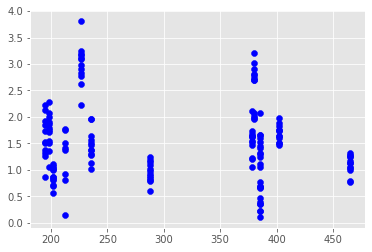

In [38]:
#crowne plaza SPOR plot
crowne_mask = test_hotels['Flag'] == 'Crowne Plaza'
crowne_df = test_hotels[crowne_mask]
print(crowne_df)
x = crowne_df['#Rooms']
y1 = crowne_df['SPOR']
plt.scatter(x, y1, color = 'b')
# plt.savefig('../images/crowne_SPOR.png')

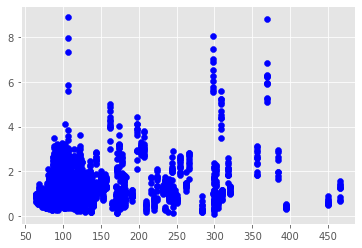

In [39]:
hilto_mask = test_hotels['Brand'] == 'Hilto'
hilto_df = test_hotels[hilto_mask]
x = hilto_df['#Rooms']
y = hilto_df['SPOR']
plt.scatter(x,y, color = 'b')
plt.savefig('../images/hilto_mask.png')

In [ ]:
x_all = test_hotels['$Rooms']
y_all = test_hotels['SPOR']


In [ ]:
# hilton_mask = test_hotels['Brand'] == 'Hilto'
# hilton_df = test_hotels[hilton_mask].copy
# unique_hilton_flags = list(hilton_df